# Reading the data and pre-processing it

In [64]:
import pandas as pd
from datetime import datetime

In [79]:
dataset = pd.read_csv('data\pollution.csv')

In [ ]:
print(len(dataset))

43824


In [ ]:
null_values = dataset.isnull().any(axis = 1)
print(null_values)

0         True
1         True
2         True
3         True
4         True
         ...  
43819    False
43820    False
43821    False
43822    False
43823    False
Length: 43824, dtype: bool


In [32]:
#The null value check does not indicate the exact positions of null values      

# Pre-Processing steps:
1) Consolidate date-time information into a single date-time so that it can be used as an index in Pandas
2) NA values to be removed from pm2.5 for the first 24 hours.
3) The "No" columns is dropped and then clearer names are specidfied for each column
4) Saving the processed file as pollution1.csv

In [35]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('data\pollution.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)


In [34]:
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'


In [8]:
# marking all NA values with 0
dataset['pollution'].fillna(0, inplace = True)
# drop the first 24 hours 
dataset = dataset[24:]

In [9]:
#summarize first 5 rows
print(dataset.head(5))


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [37]:
#save to file
dataset.to_csv('data\pollution1.csv')

# Plotting
Plotting all attributes with respect to time except wind speed dir (since it is categorical)

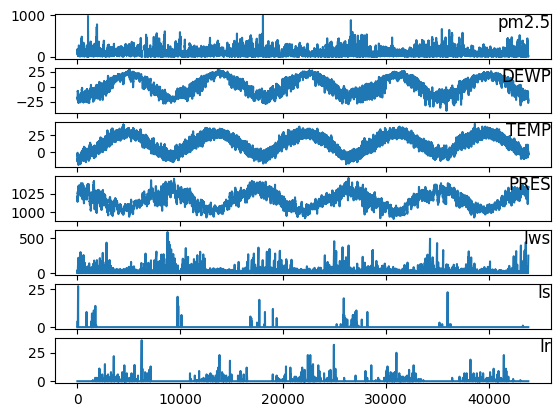

In [66]:
from matplotlib import pyplot
dataset = pd.read_csv('data\pollution1.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()


# Prepare data for lstm


In [68]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [69]:
# creating a function: convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    if type(data) is list:
        n_vars = 1
    else:
        n_vars = data.shape[1]
    
    df = DataFrame(data)

    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        shifted_df = df.shift(i)
        cols.append(shifted_df)

        for j in range(n_vars):
            col_name = 'var%d(t-%d)' % (j+1, i)
            names.append(col_name)
    

    
    # forecast sequence (t-n, ... , t-1)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # putting it all together
    agg = concat(cols, axis = 1)
    agg.columns = names
    #drop rows with Nan values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

        
        


In [70]:
# Loading the dataset
dataset = pd.read_csv('data\pollution1.csv', header = 0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

#normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)



In [71]:
# Applying the feature to the model
# frame as supervised learning

reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis = 1, inplace= True)
print(reframed.head())


    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
25   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
26   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
27   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
28   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
29   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

    var7(t-1)  var8(t-1)   var1(t)  
25   0.000000        0.0  0.148893  
26   0.000000        0.0  0.159960  
27   0.000000        0.0  0.182093  
28   0.037037        0.0  0.138833  
29   0.074074        0.0  0.109658  


In [72]:
x = pd.read_csv('data/pollution1.csv')
print(x.shape[1])

9


In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Define and Fit Model

In [74]:
...
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (32783, 1, 8) (32783,)


Epoch 1/50
122/122 - 3s - loss: 0.0518 - val_loss: 0.0426 - 3s/epoch - 28ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0324 - val_loss: 0.0430 - 759ms/epoch - 6ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0180 - val_loss: 0.0428 - 764ms/epoch - 6ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0151 - val_loss: 0.0330 - 779ms/epoch - 6ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0242 - 770ms/epoch - 6ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0144 - val_loss: 0.0198 - 775ms/epoch - 6ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0142 - val_loss: 0.0180 - 769ms/epoch - 6ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0142 - val_loss: 0.0167 - 811ms/epoch - 7ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0142 - val_loss: 0.0156 - 742ms/epoch - 6ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0141 - val_loss: 0.0155 - 852ms/epoch - 7ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0141 - val_loss: 0.0152 - 767ms/epoch - 6ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0142 - val_loss: 0.0150 - 771ms/epoch - 6ms/step
Epo

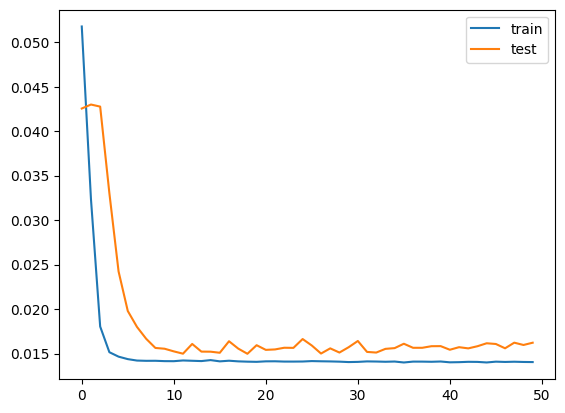

In [76]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Evaluate Model

In [77]:
import numpy as np
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from math import sqrt

In [78]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

1025/1025 [==============================] - 2s 1ms/step
Test RMSE: 26.457
